**Table of contents**<a id='toc0_'></a>    
- [Знакомство с данными](#toc1_)    
- [Визуализация](#toc2_)    
- [Выводы:](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlflow.client import MlflowClient
TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "eda_exp" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")


/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/home/mle-user/mle_projects/.venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


# <a id='toc1_'></a>[Знакомство с данными](#toc0_)

Загрузить данные в Jupyter Notebook, используя библиотеку pandas. Убедиться, что провели предварительную обработку данных, затронув пропущенные значения и преобразование типов данных.

In [2]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [3]:
client = MlflowClient()
# Получаем список артефактов
runs = client.search_runs(17)
for run in runs:
    if run.info.status !='FAILED':
        artifacts = client.list_artifacts(run.info.run_id)
        if artifacts[0].path == 'initial_data.csv':
            run_id = run.info.run_id
local_path = client.download_artifacts(run_id, "initial_data.csv", 'data')
df = pd.read_csv(local_path)
df.sample(5)

,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,nearest_metro,distance_to_metro
68573,2,False,8.6,21.000000,1,False,39.000000,9550000,1982,4,2.64,570,12,True,Шелепиха,3.649226
89503,7,False,13.3,44.700001,3,False,80.699997,18500000,2002,4,2.74,332,17,True,Петровский парк,11.728803
48868,8,False,9.0,32.000000,2,False,54.000000,19200000,2010,4,2.64,156,14,True,Петровский парк,6.101205
29296,2,False,8.5,31.799999,2,False,52.400002,16000000,1983,4,2.64,220,2,True,Петровский парк,10.538898
45159,13,False,9.8,30.299999,2,False,51.700001,9200000,2013,4,2.74,384,17,True,Новокосино,8.550892


In [4]:
df.isna().sum()

floor                0
is_apartment         0
kitchen_area         0
living_area          0
rooms                0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
nearest_metro        0
distance_to_metro    0
dtype: int64

*Вывод:* Пропуски в данных отсутствуют.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127044 entries, 0 to 127043
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   floor              127044 non-null  int64  
 1   is_apartment       127044 non-null  bool   
 2   kitchen_area       127044 non-null  float64
 3   living_area        127044 non-null  float64
 4   rooms              127044 non-null  int64  
 5   studio             127044 non-null  bool   
 6   total_area         127044 non-null  float64
 7   price              127044 non-null  int64  
 8   build_year         127044 non-null  int64  
 9   building_type_int  127044 non-null  int64  
 10  ceiling_height     127044 non-null  float64
 11  flats_count        127044 non-null  int64  
 12  floors_total       127044 non-null  int64  
 13  has_elevator       127044 non-null  bool   
 14  nearest_metro      127044 non-null  object 
 15  distance_to_metro  127044 non-null  float64
dtypes:

*Вывод:* Типы данных соответствуют экономической сути колонок.

# <a id='toc2_'></a>[Визуализация](#toc0_)
Визуализируем данные, построив графики при помощи библиотек Matplotlib и Seaborn, — так мы наглядно представим распределение признаков, в том числе целевую переменную.

In [6]:
def group_others(series):
    # Получаем 10 самых крупных значений
    if len(series) > 10:
        top_values = series.nlargest(9)
        # Суммируем остальные значения
        others_sum = series[~series.isin(top_values)].sum()
        top_values['прочие']= others_sum
    else:
        top_values = series.nlargest(len(series))
        top_values.index = [str(x) for x in top_values.index]

    
    return top_values

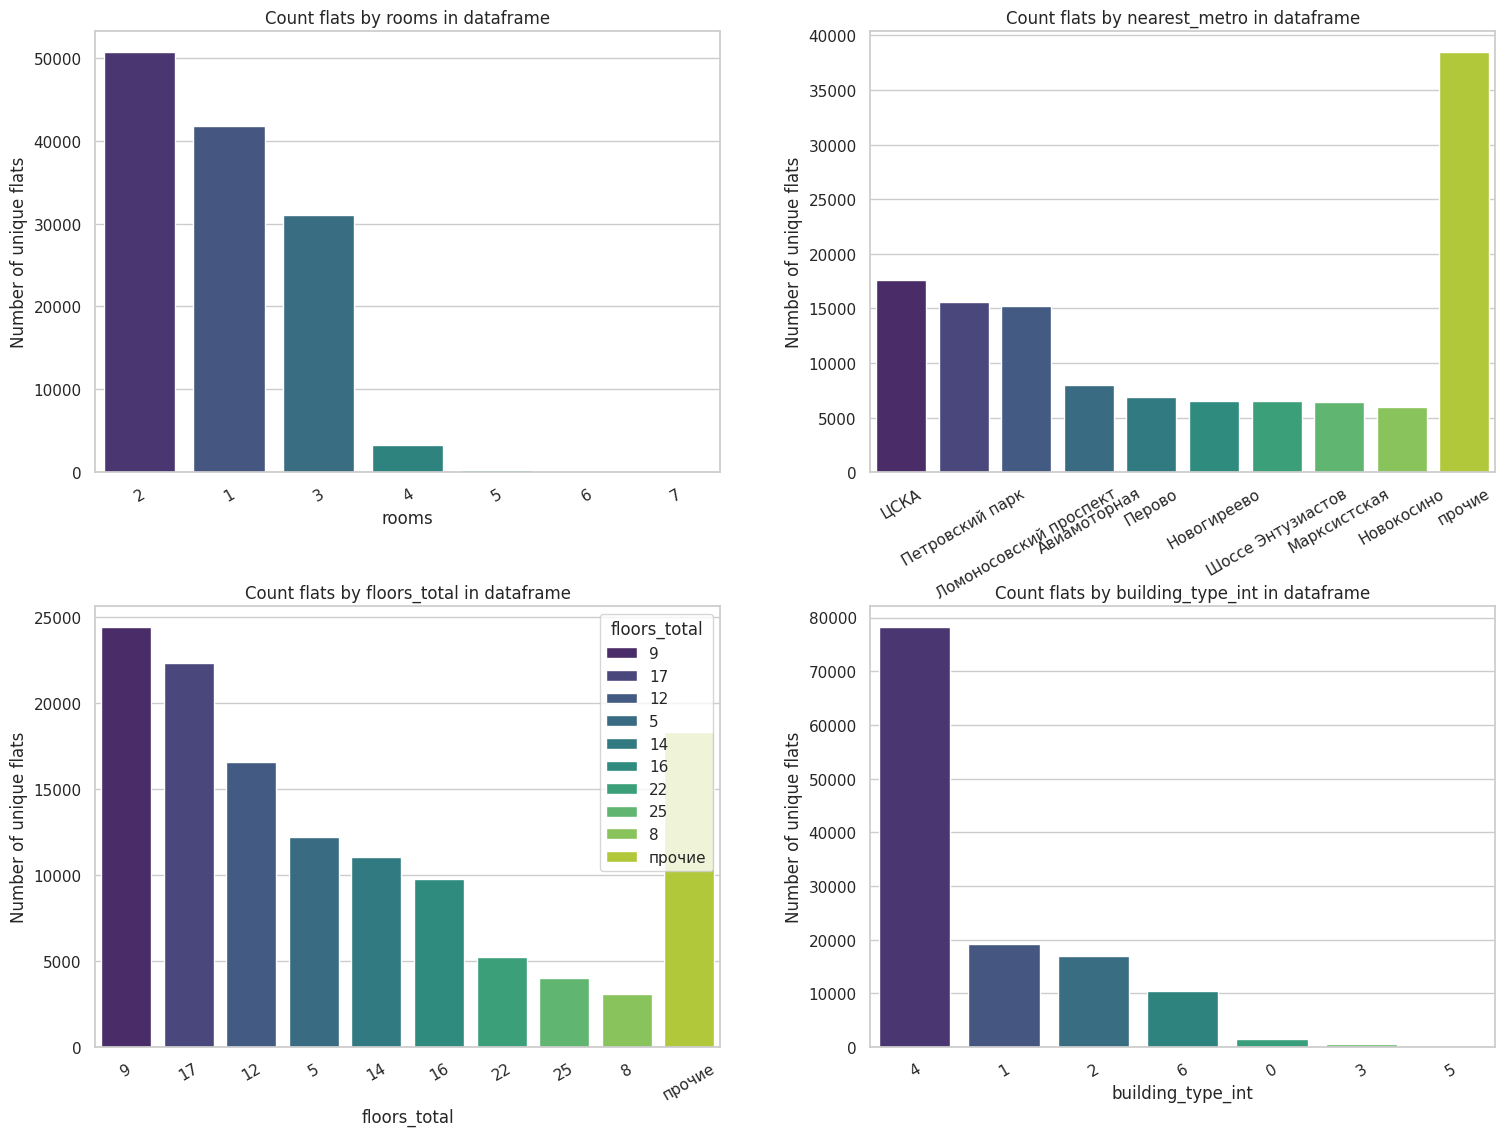

In [7]:
import matplotlib.colors as mcolors
df['id']=df.index
fig, axs = plt.subplots(2, 2, figsize=(16.5, 12.5))
fig.tight_layout(pad=6)
groups = ['rooms', 'nearest_metro', 'floors_total', 'building_type_int']
for i, group in enumerate(groups):
    grouped_data = df.groupby(group)['id'].nunique()
    grouped_data = group_others(grouped_data)
    sns.barplot(x=grouped_data.index, y=grouped_data.values, ax=axs[i//2, i%2], palette='viridis', hue = grouped_data.index)
    axs[i//2, i%2].set_title(f'Count flats by {group} in dataframe')
    axs[i//2, i%2].xaxis.set_ticks([str(x) for x in grouped_data.index])
    axs[i//2, i%2].set_xticklabels(grouped_data.index, rotation = 30)
    axs[i//2, i%2].set_ylabel('Number of unique flats')
    axs[i//2, i%2].set_xlabel(group)
plt.savefig(f'{ASSETS_DIR}/cat_features_1.png')
plt.show()


In [8]:
binary_cols = df.columns[df.nunique() == 2]

for c in binary_cols:
    df[c].replace({True: 1, False: 0}, inplace=True)
df[binary_cols]

,is_apartment,has_elevator
0,0,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
127039,0,1
127040,0,1
127041,0,1
127042,0,1


/tmp/ipykernel_4007/2459221338.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = binary_df.apply(pd.value_counts).unstack().unstack()


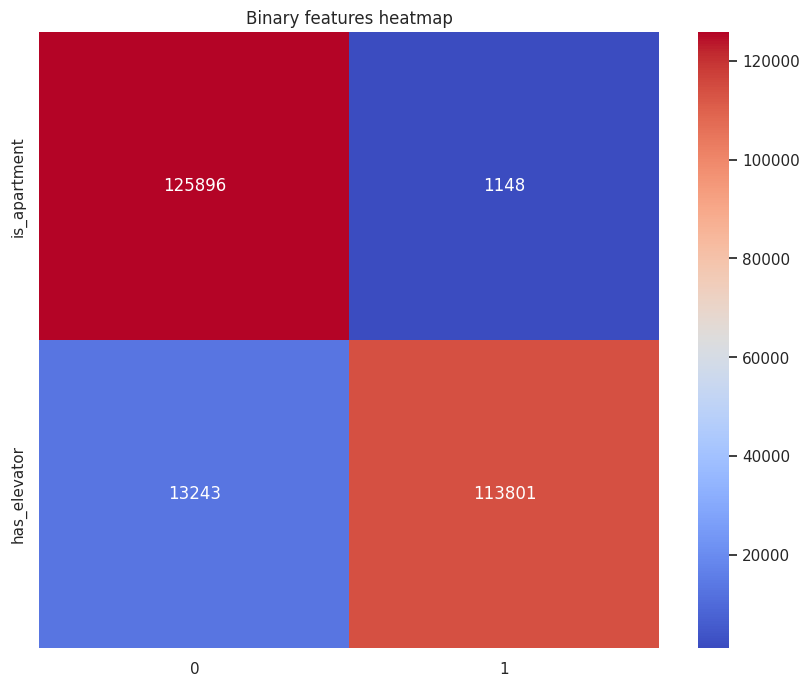

In [9]:
# Создаем таблицу с бинарными признаками
binary_df = df[binary_cols]
# Создаем таблицу с количеством раз, когда каждый признак принимает значение 1 или 0
counts = binary_df.apply(pd.value_counts).unstack().unstack()
# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(counts, annot=True, cmap='coolwarm', fmt=".0f")
plt.title('Binary features heatmap')
plt.savefig(f'{ASSETS_DIR}/cat_features_2_binary_heatmap.png')
plt.show()

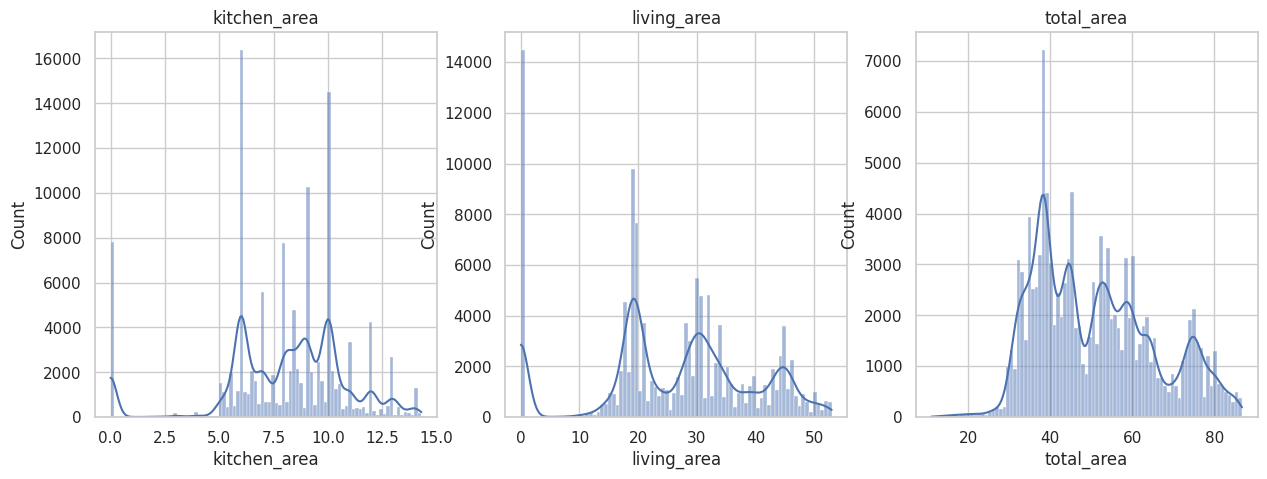

In [10]:
# список колонок, для которых будут вычисляться статистики
square_columns = [
    "kitchen_area",
    "living_area",
    "total_area",
]
# Создаем фигуру
fig, axs = plt.subplots(1, len(square_columns), figsize=(15, 5))

# Выводим графики
for i, col in enumerate(square_columns):
    data = df[col][df[col] <= df[col].quantile(0.95)]
    sns.histplot(data, ax=axs[i], kde=True)
    axs[i].set_title(col)
plt.savefig(f'{ASSETS_DIR}/histograms.png')
plt.show()


А вот объекты где жилая площадь равна нулю надо исследовать.

In [11]:
sub = df[df['living_area']==0]
sub.sample(12)

,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,build_year,building_type_int,ceiling_height,flats_count,floors_total,has_elevator,nearest_metro,distance_to_metro,id
43480,3,0,0.0,0.0,3,False,82.099998,19850000,2015,2,2.80,156,14,1,Новогиреево,6.939778,43480
10654,3,0,18.0,0.0,1,False,38.000000,13900000,2018,2,3.00,242,23,1,ЦСКА,7.898115,10654
45026,5,0,0.0,0.0,3,False,61.200001,13580280,2018,2,3.00,321,16,1,Озёрная,9.076598,45026
26148,7,0,6.1,0.0,3,False,58.400002,16300000,1970,4,2.64,355,9,1,Площадь Ильича,10.446032,26148
76868,5,0,0.0,0.0,2,False,44.000000,12300000,1960,4,2.48,80,5,0,Шоссе Энтузиастов,7.242296,76868
11936,3,0,10.0,0.0,3,False,70.000000,13700000,1988,4,2.48,474,16,1,Марксистская,16.271241,11936
12591,5,0,6.0,0.0,1,False,40.000000,9500000,2019,2,2.65,224,16,1,Ломоносовский проспект,18.566457,12591
61295,8,0,15.0,0.0,2,False,56.099998,13150000,1987,4,2.64,463,17,1,Третьяковская,13.058371,61295
101042,6,0,0.0,0.0,2,False,55.000000,18000000,2004,4,3.00,64,9,1,Петровский парк,6.016059,101042
13694,17,0,10.0,0.0,1,False,38.000000,7800000,2001,2,2.80,248,25,1,Перово,10.674431,13694


Видимо это досадно недоразумение. Чтобы оно не вносило шум в работу модели, признаем для этих случаев жилую площадь равной общей - площадь кухни - 4,3 метров на санузлы.
В среднестатистической квартире площадью 40–45 м² (исключая сегменты бизнес и элит) под санузел отводится ориентировочно 4–4,5 м². 

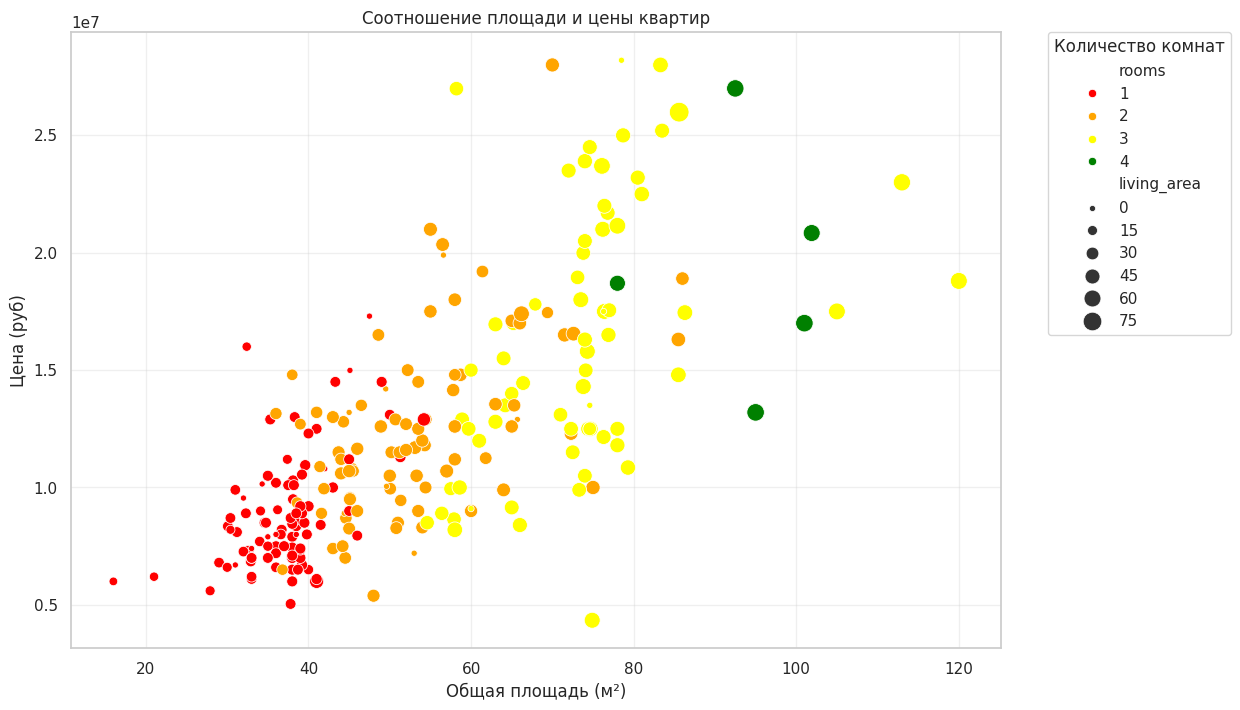

In [12]:
df1 = df.copy()
df = df.sample(250, random_state=42)

# Преобразуем размер пузырьков для лучшей визуализации
df['Размер пузырька'] = df['living_area'] * 5

# Создаем цветовую шкалу
colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'purple', 6:'blue',7:'black'}
df['Цвет'] = df['rooms'].map(colors)

# Создаем график
plt.figure(figsize=(12, 8))

# Используем seaborn для создания scatter plot
sns.scatterplot(
    x='total_area',
    y='price',
    size='living_area',
    hue='rooms',
    palette=colors,
    sizes=(20, 200),
    data=df
)

# Настраиваем оси
plt.xlabel('Общая площадь (м²)')
plt.ylabel('Цена (руб)')
plt.title('Соотношение площади и цены квартир')

# Добавляем сетку
plt.grid(True, alpha=0.3)

# Настраиваем легенду
plt.legend(title='Количество комнат', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# Показываем график
plt.savefig(f'{ASSETS_DIR}/bubbles.png')
plt.show()


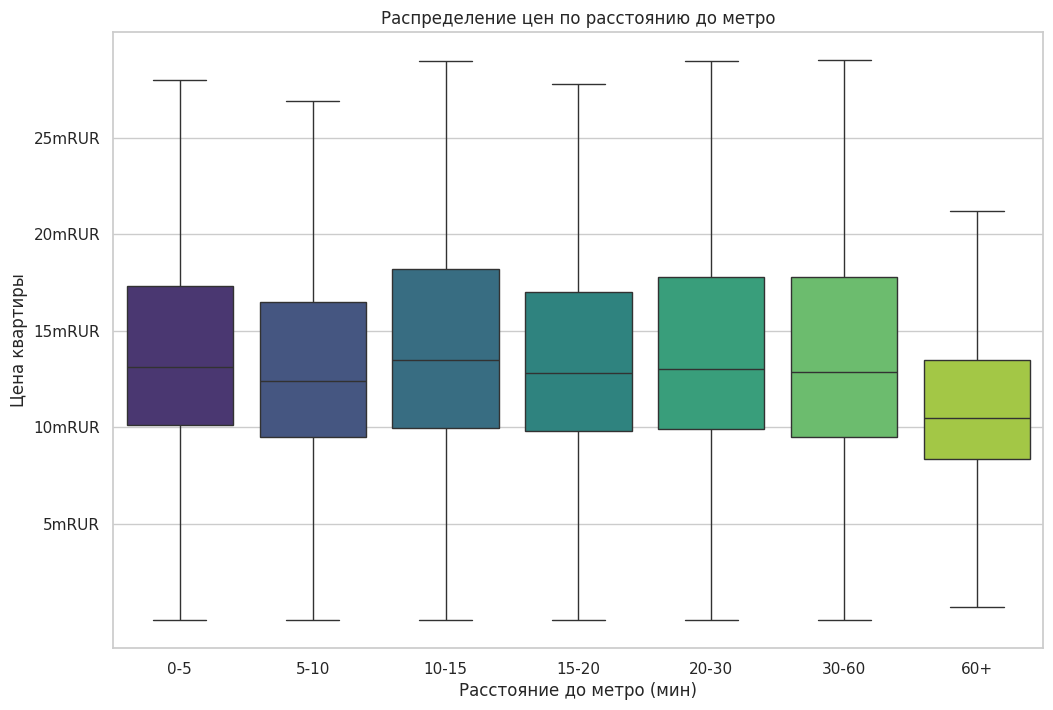

In [13]:
import numpy as np
df = df1.copy()
import plotly.graph_objects as go
# Создаем интервалы расстояния
df['Расстояние до метро (мин)']= df['distance_to_metro']/0.083333

df['Интервал'] = pd.cut(
    df['Расстояние до метро (мин)'],
    bins=[0, 5, 10, 15, 20, 30, 60, np.inf],
    labels=['0-5', '5-10', '10-15', '15-20', '20-30', '30-60','60+']
)
plt.figure(figsize=(12, 8))
df = df.sort_values(by='Интервал')
# Создаем box plot
fig = sns.boxplot(
    x='Интервал',
    y='price',
    data=df.sort_values(by='Интервал'),
    palette='viridis',
    showfliers=False,
    hue = 'Интервал'
)

# Настраиваем внешний вид
fig.set_title('Распределение цен по расстоянию до метро')
fig.set_xlabel('Расстояние до метро (мин)')
fig.set_ylabel('Цена квартиры')

# Добавляем всплывающие подсказки
fig.xaxis.set_ticks(df['Интервал'].unique())
fig.set_xticklabels(df['Интервал'].unique())
fig.yaxis.set_ticks([5000000,10000000,15000000,20000000,25000000])
fig.set_yticklabels(['5mRUR','10mRUR','15mRUR','20mRUR','25mRUR'])

# Показываем график
plt.savefig(f'{ASSETS_DIR}/time_to_metro_vs_price.png')
plt.show()


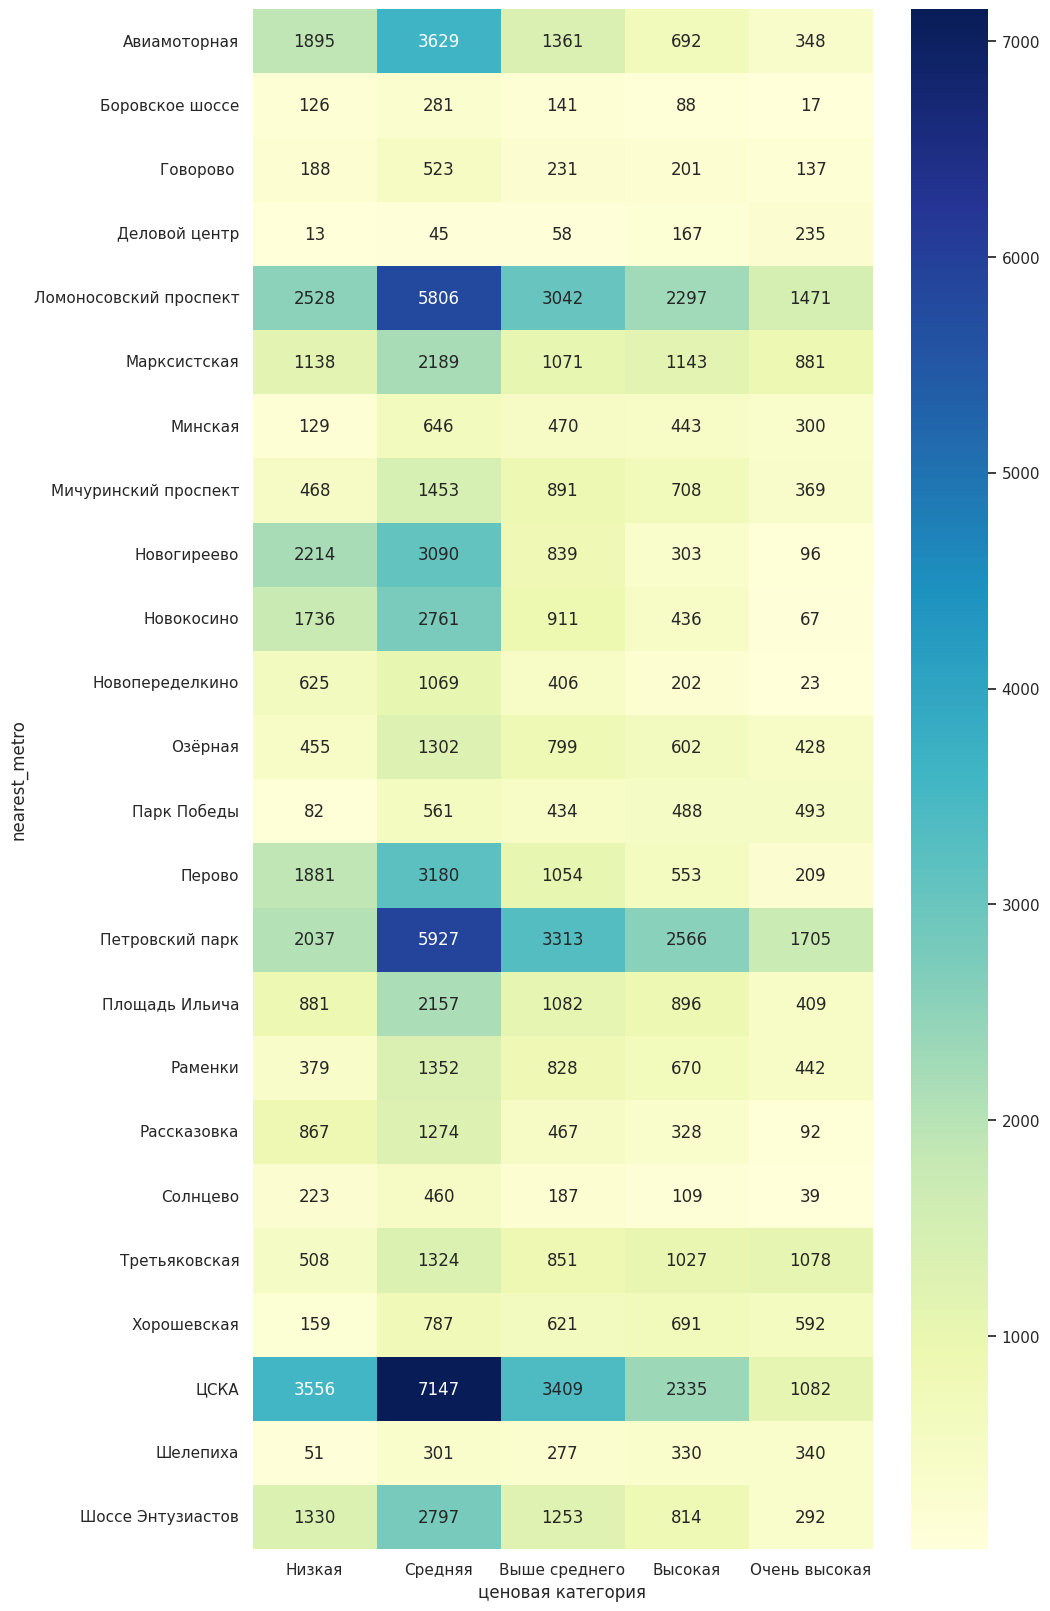

In [14]:
df= df1.copy()
#Cоздаем ценовые категории
df['ценовая категория'] = pd.cut(
    df['price'],
    bins=[3000000, 8000000, 12000000, 15000000, 20000000, np.inf],
    labels=['Низкая', 'Средняя', 'Выше среднего', 'Высокая', 'Очень высокая']
)
df['медиана рынка'] = df.groupby('nearest_metro')['price'].transform('median')
# Создаем тепловую карту
plt.figure(figsize=(10, 20))
sns.heatmap(df.pivot_table(index='nearest_metro', columns='ценовая категория', values='price', aggfunc='count'), annot=True, cmap='YlGnBu', fmt=".0f")

# Добавляем наложение медианы рынка
plt.plot(df['nearest_metro'], df['медиана рынка'], color='red', linewidth=2)
plt.savefig(f'{ASSETS_DIR}/price_dist_by_metro.png')
plt.show()


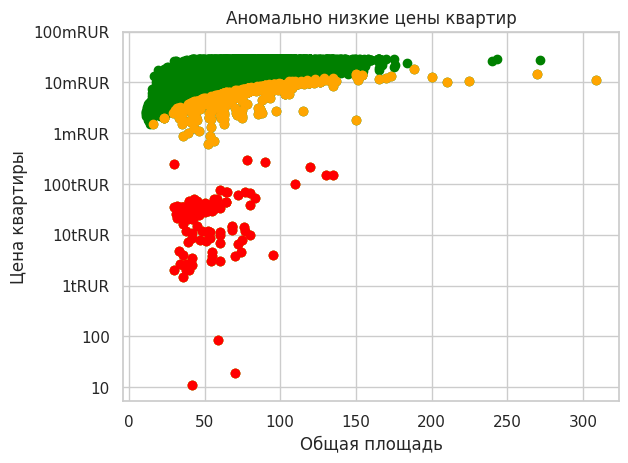

In [15]:
df['Цена_метра']= df['price']/df['total_area']
min = df['price'].quantile(0.02)
anomalies = df[df['price'] < min]
min = anomalies['Цена_метра'].quantile(0.15)
sub = df[df['Цена_метра'] < min]
sub_sub = df[df['price'] < 500000]
plt.scatter(df['total_area'], df['price'], c='green')
plt.scatter(sub['total_area'], sub['price'], c='orange')
plt.scatter(sub_sub['total_area'], sub_sub['price'], c='red')
plt.title('Аномально низкие цены квартир')
plt.xlabel('Общая площадь')
plt.gca().set_yscale('log')
plt.gca().yaxis.set_ticks([10,100,1000,10000,100000,1000000,10000000, 100000000])   
plt.gca().set_yticklabels(['10','100','1tRUR','10tRUR','100tRUR','1mRUR','10mRUR', '100mRUR']) 
plt.ylabel('Цена квартиры')
plt.savefig(f'{ASSETS_DIR}/anomalies_low.png')
plt.show()


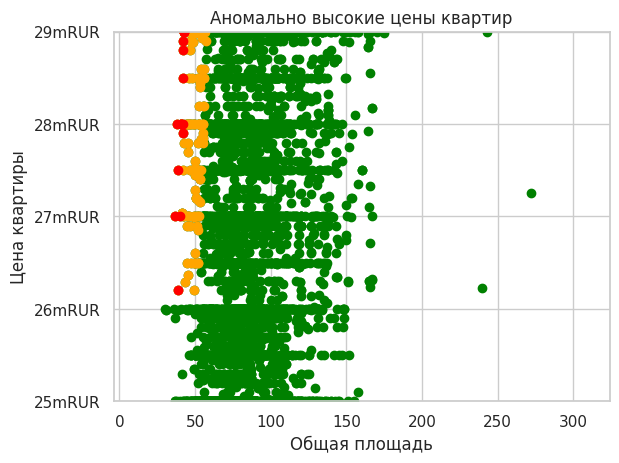

In [16]:
max = df['price'].quantile(0.98)
anomalies = df[df['price'] > max]
max = anomalies['Цена_метра'].quantile(0.95)
sub = anomalies[anomalies['Цена_метра'] > max]
sub_sub = sub[sub['Цена_метра'] > max*1.3]
plt.scatter(df['total_area'], df['price'], c='green')
plt.scatter(sub['total_area'], sub['price'], c='orange')
plt.scatter(sub_sub['total_area'], sub_sub['price'], c='red')
plt.title('Аномально высокие цены квартир')
plt.xlabel('Общая площадь')
#plt.gca().set_yscale('log')
plt.gca().set_ylim(bottom=25000000, top=29000000)

plt.gca().yaxis.set_ticks([25000000,26000000,27000000,28000000, 29000000])   
plt.gca().set_yticklabels(['25mRUR', '26mRUR','27mRUR','28mRUR','29mRUR']) 

plt.ylabel('Цена квартиры')
plt.savefig(f'{ASSETS_DIR}/anomalies_high.png')
plt.show()


*Вывод:* Визуальный анализ данных позволяет говорить о следующих особенностях набора данных:
1. Гипотеза о том, что дальность от метро однозначно определяет стоимость квартиры в Москве. Медианы на самом деле в одном диапазоне, а разброс цен очень велик, независимо от этого фактора.
2. Наблюдаются аномально низкие цены, которые по всей вероятноси обусловлены некорректным вводом данных, например введина цена аренды в месяц, вместо стоимости продажи. Есть смысл ограничить нижнуюю границу 1 млн. руб.
3. Обнаружено большое количество некорректных значений по признаку жилой площади. Нужно будет пересчитать этот показатель исходя из других параметров жилья.

In [17]:
markdown_text='''*Вывод:* Визуальный анализ данных позволяет говорить о следующих особенностях набора данных:
1. Гипотеза о том, что дальность от метро однозначно определяет стоимость квартиры в Москве. Медианы на самом деле в одном диапазоне, а разброс цен очень велик, независимо от этого фактора.
2. Наблюдаются аномально низкие цены, которые по всей вероятноси обусловлены некорректным вводом данных, например введина цена аренды в месяц, вместо стоимости продажи. Есть смысл ограничить нижнуюю границу 1 млн. руб.
3. Обнаружено большое количество некорректных значений по признаку жилой площади. Нужно будет пересчитать этот показатель исходя из других параметров жилья.'''
with open(f'{ASSETS_DIR}/eda_summary.md', 'w') as file:
    file.write(markdown_text)

In [21]:

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}") 
mlflow.set_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
with mlflow.start_run(run_name=f"{RUN_NAME}_intersection_and_union", experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    mlflow.log_artifacts(ASSETS_DIR) 
    notebook = 'eda.ipynb'
    mlflow.log_artifact(notebook, 'eda.ipynb')